# Introduction: nonlinear and causal timeseries analysis with Julia

_Keep in mind: theoretical background on **delay coordinates embedding** is useful to **understand** the methodological approach and to make better decisions regarding the parameters of the algorithms. On the bright side, to understand the code, delay embedding knowledge isn't necessary. In practice this means that you can learn to use this code base and return to it again after having learnt delay coordinates embedding_

Quick theme change for plotting in zoomed-in Jupyter notebooks:

In [1]:
using CairoMakie
update_theme!(resolution = (500, 300), fontsize = 16)

# ComplexityMeasures.jl

ComplexityMeasures.jl is the most complete and most and performant software for computing quantities relevant in nonlinear timeseries analysis. 

"Nonlinear" timeseries analysis is a generic term that in simply means: "extract quantities from the timeseries that are inspired by nonlinear dynamics processes and quantify _dynamic_ information about the data". Dynamic information is information about _how data change with time_. This is contrasting to statistical information (such as mean or variance), which remain invariant if you shuffle the data randomly.

## Probabilities from timeseries

Complexity measures are estimated from _probability distributions_. Hence, the data first need to be cast into a form of a probability distribution. ComplexityMeasures.jl offers a `ProbabilitiesEstimator` interface. Various estimators are offered and their role is to decide how discrete probabilities are extracted from data when given to the `probabilities` function. The syntax is simple:
```julia
probabilities(est::ProbablitiesEstimator, x)
```

### `ValueHistogram`

A way to cast data into probabilities that most will be familiar with is to get their histogram, which is what the estimator `ValueHistogram` does.

In [2]:
using ComplexityMeasures
probest = ValueHistogram(21); # makes histogram with `21` bins per dimension

To demonstrate, let's apply this estimator to an example timeseries:

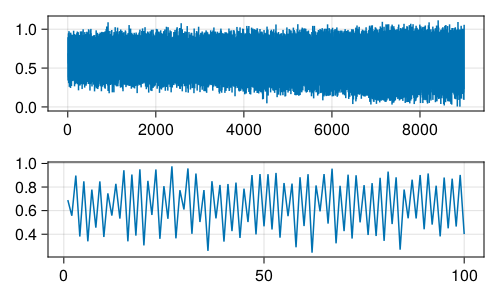

In [3]:
using Downloads, DelimitedFiles
file = Downloads.download("https://raw.githubusercontent.com/JuliaDynamics/NonlinearDynamicsTextbook/master/exercise_data/7.csv")
x = vec(DelimitedFiles.readdlm(file))
fig, = lines(x)
lines(fig[2,1], x[1:100])
fig

To extract probabilities, call the `probabilities` function and give it the probabilities estimator and the input data `x`:

In [4]:
probs = probabilities(probest, x)

21-element Probabilities{Float64, 1}:
 0.002221235006663705
 0.010328742780986229
 0.02665482007996446
 0.035650821856952467
 0.03698356286095069
 0.04531319413593958
 0.04320302087960906
 0.049089293647267884
 0.055308751665926255
 0.0504220346512661
 ⋮
 0.057418924922256774
 0.061417147934251445
 0.07385606397156819
 0.09062638827187916
 0.10561972456685917
 0.09195912927587739
 0.05053309640159929
 0.012549977787649933
 0.0016659262549977788

21 probability values were returned, each for each constructed bin. Let's visualize them

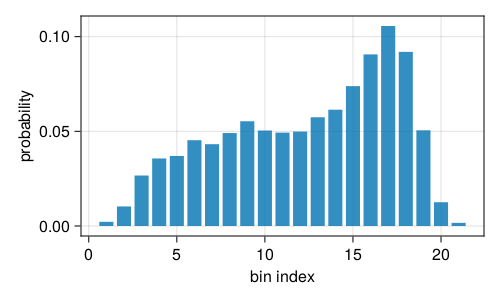

In [5]:
fig, ax = barplot(probs)
ax.xlabel = "bin index"
ax.ylabel = "probability"
fig

As you see, `probabilities` returns only the probabilities themselves. If you want the _outcomes_ corresponding to the probabilities, you need to call `probabilities_and_outcomes`. "Outcomes" here is a general word, and what it represents depends on the probabilities estimator. For `ValueHistogram` the outcomes are the left edges of each bin.

In [6]:
probs, outs = probabilities_and_outcomes(probest, x)
outs

21-element Vector{SVector{1, Float64}}:
 [0.003182203478959325]
 [0.05609759606942281]
 [0.10901298865988629]
 [0.16192838125034978]
 [0.21484377384081324]
 [0.26775916643127673]
 [0.3206745590217402]
 [0.3735899516122037]
 [0.42650534420266717]
 [0.4794207367931307]
 ⋮
 [0.6381669145645211]
 [0.6910823071549846]
 [0.743997699745448]
 [0.7969130923359116]
 [0.8498284849263751]
 [0.9027438775168385]
 [0.955659270107302]
 [1.0085746626977654]
 [1.061490055288229]

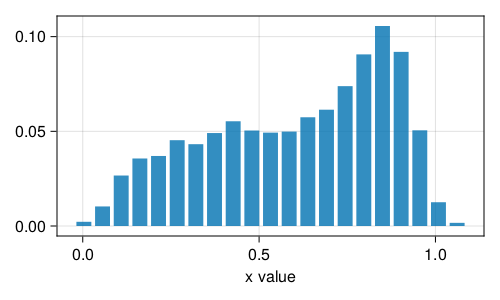

In [7]:
outs = reinterpret(Float64, outs) # outs are always vectors of vectors, even for 1D
fig, ax = barplot(outs, probs)
ax.xlabel = "x value"
fig

### `SymbolicPermutation` 

An alternative way to cast data into probabilities is using _symbolic permutations_, also known as _ordinal patterns_. This is done by the estimator `SymbolicPermutation`, which takes in an order `m` as an argument.

In [8]:
probest = SymbolicPermutation(m = 3);

We can extract probabilities and plot them just like before, but now the plot won't be the "traditional histogram" we are familiar with, but a probability mass function (discrete probability density)

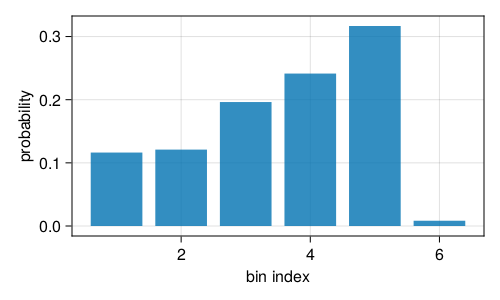

In [9]:
probs = probabilities(probest, x)
fig, ax = barplot(probs)
ax.xlabel = "bin index"
ax.ylabel = "probability"
fig

The outcomes corresponding to the above probabilities are the _ordinal patterns_ of `m`-consecutive points of the timeseries `x`.

Here is some fancy visualizing code that makes things clear:

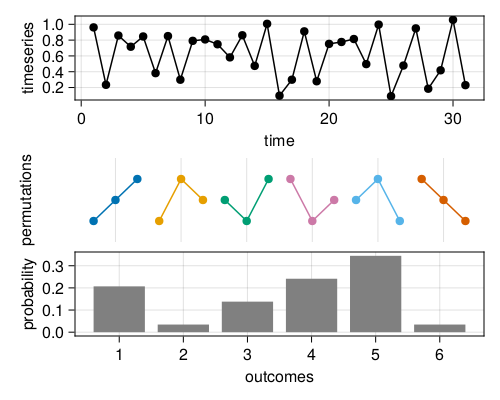

In [10]:
xsmall = x[end-30:end]
fig = Figure(resolution = (500,400))
scatterlines(fig[1,1], xsmall; color = "black",
    axis = (ylabel = "timeseries", xlabel = "time"), 
)
# Obtain, and then plot, the ordinal patterns (i.e., the outcomes!)
probest = SymbolicPermutation(m = 3)
probs, outs = probabilities_and_outcomes(probest, xsmall)
ax_outs = Axis(fig[2,1]; ylabel = "permutations", xticks = (2:3:19, string.(1:6)))
ylims!(ax_outs, 0, 4)
for (i, o) in enumerate(outs)
    s = Vector(sortperm(o))
    scatterlines!(ax_outs, 3*(i-1) .+ (1:3), s)
end
hidespines!(ax_outs)
hideydecorations!(ax_outs; label = false)
hidexdecorations!(ax_outs; grid = false)
ax_outs.ylabelpadding = 40
# Plot also the probabilities for each permutation
barplot(fig[3,1], probs; color = "gray", 
    axis = (xticks = 1:6, xlabel = "outcomes", ylabel = "probability")
)
rowgap!(fig.layout, 10)

fig

## Obtaining complexity measures

### Entropies

While these probabilities are fine, what we really care about is computing the entropy of these probabilities. To be precise, we will compute the _Shannon entropy_. ComplexityMeasures.jl offers many other entropies, but in this simple tutorial we keep things basic. Shannon entropy is defined by

$$
H(p) = - \sum_i p[i] \log(p[i])
$$

To compute an entropy directly from a probability mass function you simply call the `entropy` function, which by default will compute the Shannon entropy:

In [11]:
probest = SymbolicPermutation(m = 3)
probs = probabilities(probest, x)

6-element Probabilities{Float64, 1}:
 0.1163074872250611
 0.1209731170850922
 0.1962897133970229
 0.24139080204399022
 0.31670739835592093
 0.008331481892912686

In [12]:
H = entropy(probs)

2.2686044733938613

It is almost aways preferred to compute the _normalized_ entropy, which is the above value divided by the maximum possible value for the entropy. The maximum possible value cannot be deduced directly from a probabilities container, because typically events with 0 probability are ignored and not even included in the computed probabilities. But no problem, we can call `entropy_normalized` with the probabilities estimator and the input data, which computes the probabilities and maximum entropy automatically and returns the normalized result.

In [13]:
h = entropy_normalized(probest, x)

0.8776160090372542

What we calculated above is the (normalized) **permutation entropy**. This quantifier of timeseries complexity is one of the most frequently used quantities in the context of nonlinear timeseries analysis. The smaller `h` is, the more regular and more predictable the timeseries is. Contrarily, the closer to 1 `h` is, the more noisy and random the timeseries is. Additionally, computing `h` is ultra fast, robust versus noise, and invariant under monotonic transformations of input timeseries `x`.

Of course, _any_ valid probabilities estimator may be used instead of `SymbolicPermutation` in the call of `entropy_normalized`, and this again will compute the corresponding entropy of the probabilities associated with the given probabilities estimator. For example

In [14]:
h = entropy_normalized(probest, x) 

0.8776160090372542

In [15]:
h_histo = entropy_normalized(ValueHistogram(21), x)

0.9359699420721946

### Other complexity measures

We have seen 2 out of the 5 core components of ComplexityMeasures.jl: `ProbabilitiesEstimator` and the `probabilities` function, and the default case of the `entropy` function applied either to a probability mass function or a probabilities estimator. The next 2 core components of ComplexityMeasures.jl are alternative definitions of discrete entropies, and differential entropies. We won't discuss these in this introductory level.

The 5th core component is the `complexity` function, which is called when calculating other complexity measures that are not entropies in the strict mathematical definition. `complexity` works practically identically to `entropy`. First, one chooses a `ComplexityEstimator`, and calls `complexity` with this estimator and input data.

In [16]:
complest = SampleEntropy(; r = 0.25)
c = complexity(complest, x)

0.35383430034769503

and similar with `entropy`, there is also a `complexity_normalized` function, which in the majority of cases is the preferred function to use

In [17]:
c = complexity_normalized(complest, x)

0.020199312013699833

The quantity we computed above is the (normalized) **sample entropy**. It has been developed to be particularly useful in the analysis of physiological timeseries, which are characterized by very short lengths and low signal-to-noise ratio.

_Warning: even though it is named "entropy", sample entropy is not an entropy in the strict mathematical sense!_

## Application: detecting changes of dynamical behavior

There are many different application scenarios one can use these complexity measures for. Examples include classification of timeseries, surrogate testing (second block), and more. Here we highlight another useful application, detecting changes in the dynamics.


The timeseries we have been using so far is generated by a non-stationary nonlinear dynamical system (the logistic map), also with added observational Gaussian noise. While the generating dynamics are mostly chaotic, a transition to complete periodic dynamics occurs during the system evolution. Let's try to see if we can detect when this happens numerically by using the aforementioned complexity measures. Let's also compare with standard statistical quantifiers.

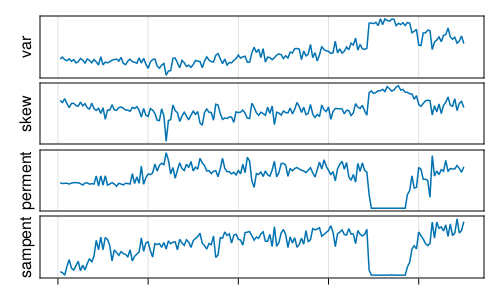

In [72]:
using StatsBase: var, skewness
# Collect measures to apply over a sliding window
measures = [
    var,
    skewness,
    x -> entropy_normalized(SymbolicPermutation(m = 3), x), # permutation entropy
    x -> complexity_normalized(SampleEntropy(r = 0.25), x), # sample entropy
]
labels = ["var", "skew", "perment", "sampent"]
# compute all measures over a sliding window of `x`
window = 50
function apply_over_sliding_window(f, x, w)
    map(1:w:(length(x)-w)) do i
        z = view(x, i:(i+w))
        f(z)
    end
end
measures_mapped = map(f -> apply_over_sliding_window(f, x, window), measures)
# Plot results
fig = Figure()
for (i, m) in enumerate(measures_mapped)
    # applied = apply_over_sliding_window(f, x, window)
    ax, = lines(fig[i, 1], window:window:length(x), m, axis = (ylabel = labels[i],))
    hideydecorations!(ax; label = false)
    hidexdecorations!(ax; grid = false, ticks = i != 4)
end
rowgap!(fig.layout, 5)
fig

Alright, from looking at the complexity measure plots, where the system transitions to regular dynamics become spectacularly clear and practically completely unaffected by noise.

While there seems to be a slight plateau in the statistical measures, it isn't as clear. Besides, there is no dynamic information in the plateau either: increase of standard deviation in the timeseries means nothing without specific assumptions on the system that generated the timeseries (i.e., you'd need some external reason to associate higher variance with higher regularity in the dynamics).

## Application: categorization strength for ECG Heartbeat timeseries

The following code loads some measured timeseries of normal and abnormal heartbeats during an ECG experiment. What measures best the two categories of the timeseries?

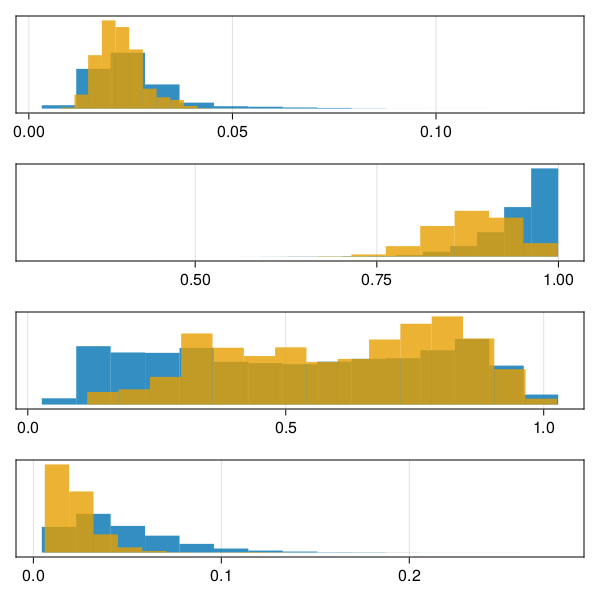

In [73]:
using DelimitedFiles
using StatsBase: var, skewness

normal = readdlm(joinpath(@__DIR__, "..", "data", "ptbdb_normal.csv"), ',')
abnormal = readdlm(joinpath(@__DIR__, "..", "data", "ptbdb_abnormal.csv"), ',')

using ComplexityMeasures

measures = [
    var,
    x -> entropy_normalized(SymbolicPermutation(m = 3), x),
    x -> entropy_normalized(WaveletOverlap(), x),
    x -> complexity_normalized(SampleEntropy(x), x),
]

using CairoMakie
fig = Figure(resolution = (600,600))

for (i, measure) in enumerate(measures)

ax = Axis(fig[i,1])
abnormal_pe = Float64[]
normal_pe = Float64[]

for row in eachrow(normal)
    # last entry is class (1 or 0), not part of time series
    ts = row[1:end-1]
    # delete padded zeros
    push!(normal_pe, measure(ts[ts .!= 0]))
end

for row in eachrow(abnormal)
    ts = row[1:end-1]
    push!(abnormal_pe, measure(ts[ts .!= 0]))
end

hist!(ax, abnormal_pe, normalization=:pdf, label="abnormal")
hist!(ax, normal_pe, normalization=:pdf, label="normal")
hideydecorations!(ax)
end

fig

A sensible way to quantify the "success" or "strength" a given measure has in categorizing the data into normal or abnormal is to quantify some kind of "distance" between these two histograms. The larger these two histograms are apart, the greater the separation! (Alternatively, the less the overlap between the histograms)

Such a distance in distribution space is a well defined concept and is called the Kullback–Leibler divergence from $q$ to $p$
$$
D_{KL}(p|q) = \sum_k p_k \log\frac{p_k}{q_k} 
$$
where here $k$ is the bin index for the histograms (for the formula to make sense here, both distributions $p, q$ must be estimated at exactly the same bins).

---

# TimeseriesSurrogates.jl

This package is the most complete and most performant software for performing timeseries surrogates hypothesis testing.

### What is a surrogate timeseries?
A surrogate of a timeseries `x` is another timeseries `s` of equal length to `x`. This surrogate `s` is generated from `x` so that it roughly preserves
one or many pre-defined properties of `x`, but is otherwise randomized.

The upper panel in the figure below shows an example of a timeseries and one
surrogate realization that (approximately) preserves its both power spectrum and its amplitude distribution (histogram). Because of this preservation, the time series look similar.

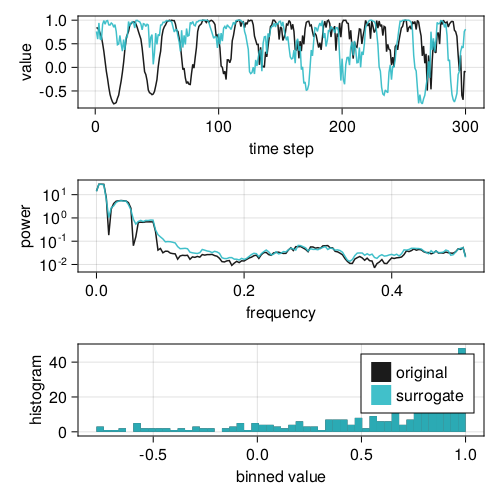

In [74]:
using TimeseriesSurrogates
using Random: Xoshiro
x = LinRange(0, 20π, 300) .+ 0.05 .* rand(300)
ts = sin.(x./rand(20:30, 300) + cos.(x))
s = surrogate(ts, IAAFT(), Xoshiro(1234))
surroplot(ts, s)


### Performing surrogate hypothesis tests

A surrogate test is a statistical test of whether a given timeseries satisfies or not a given hypothesis regarding its properties or origin.

For example, the first surrogate methods were created to test the hypothesis,
whether a given timeseries `x` that appears noisy may be the result of a linear
stochastic process or not. If not, it may be a nonlinear process contaminated with observational noise.

To perform such a surrogate test, you need to:

1. Decide what hypothesis to test against
2. Pick a surrogate generating `method` that satisfies the chosen hypothesis
3. Pick a suitable discriminatory statistic `q` with `q(x) ∈ Real`. It should be a statistic that would obtain sufficiently different values for timeseries satisfying, or not, the chosen hypothesis.
4. Compute `q(s)` for thousands of surrogate realizations `s = surrogate(x, method)`
5. Compare `q(x)` with the distribution of `q(s)`. If `q(x)` is significantly outside the e.g., 5-95 confidence interval of the distribution, the hypothesis is rejected.

## Example using TimeseriesSurrogates.jl

For this example we will stick with one of the first usage cases of the methodology: testing whether a timeseries can be interpreted as a linear stochastic process or not.

TimeseriesSurrogates.jl provides 21 different methods for generating surrogates. Each method is fully documented, and in its documentation string explains for what kind of hypothesis it is suitable for. One would have to find the appropriate ones for this hypothesis. For our application, the most basic suitable method is `RandomFourier()` that generates timeseries with same power spectrum as the original one.

In [75]:
using TimeseriesSurrogates
method = RandomFourier()

RandomFourier(true)

Let's see how a timeseries that actually _does follow_ a linear stochastic process looks like, as well as how its surrogate looks like!

In [76]:
using Random: Xoshiro  # for reproducibility
rng = Xoshiro(1234567) # random number generator
n = 400 # timeseries length
x = TimeseriesSurrogates.AR1(; n_steps = n, k = 0.25, rng); # example timeseries

To generate a surrogate you simply call the `surrogate` function

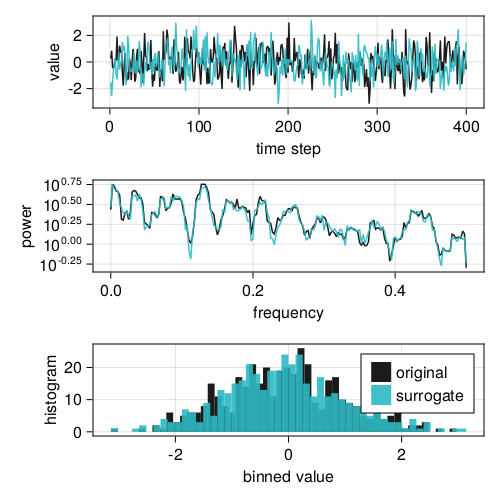

In [77]:
s = surrogate(x, method)
using CairoMakie
surroplot(x, s) # comparison plot of two timeseries

As you can see in the plot, the method `RandomFourier()` approximately preserves the power spectrum of the original timeseries, but not its amplitude distribution.

To perform a surrogate test now we need to choose a discriminatory statistic; in our case this could be something that gives information about temporal correlations such as the self-mutual-information, or something that gives information about structure in state space that a nonlinear system would have, such as the fractal dimension. Since we have already gone through ComplexityMeasures.jl, a simple discriminatory statistic that takes temporal information into account is the permutation entropy!

Let's perform then the surrogate test; Since we want to apply a process to many surrogate realizations, it is now best to use the `surrogenerator` interface over `surrogate`. We initialize a "surrogate generator"

In [78]:
sgen = surrogenerator(x, method)

Surrogate generator for input timeseries 400-element Vector{Float64} with method:
RandomFourier(true)

and when called as a function with 0 arguments, `sgen` generates a surrogate timeseries of `x`

In [80]:
s = sgen()

400-element Vector{Float64}:
 -1.8652584173628914
  0.12114114567402001
 -0.3332634540688838
 -0.8334371975117645
  0.8156748000450031
 -0.17463294171122362
  1.6543961274700685
 -0.4113392235431627
 -0.1151070807643575
 -1.2349565322726175
  ⋮
 -1.0133268762425782
  0.24305467320764418
 -1.436454540866839
  1.700105228903572
  0.6895815841211022
 -0.682307241490073
 -0.3843716344077638
 -2.0116559570745833
 -1.7603365368552328

Now we're ready to make a histogram of the discriminatory statistic for `x` and many other surrogates

In [81]:
using ComplexityMeasures

m = 3 # order of permutation
N = 10_000 # how many surrogates to use
q = x -> entropy_normalized(SymbolicPermutation(; m), x)
qx = q(x)
qs = map(q, (sgen() for _ in 1:N))

10000-element Vector{Float64}:
 0.9953176768511907
 0.9955048838600135
 0.9909668240752376
 0.9929188624159083
 0.9952426167049514
 0.9943974789132357
 0.9960478559505236
 0.9982462770245442
 0.9948062907114076
 0.9994203912940167
 ⋮
 0.9978603339533081
 0.992963966044647
 0.995005293623195
 0.9965552157465509
 0.9974081076986967
 0.9965183803332617
 0.998407309187519
 0.9984420717534659
 0.9987724271839198

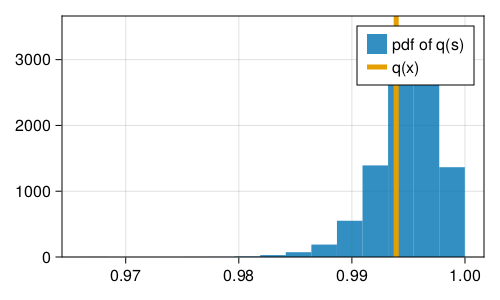

In [82]:
fig, ax = CairoMakie.hist(qs; label = "pdf of q(s)")
vlines!(ax, qx; color = Cycled(2), linewidth = 5, label = "q(x)")
axislegend(ax)
ylims!(ax, 0, nothing)
fig

In [83]:
using Statistics
q01, q99 = quantile(qs, [0.01, 0.99])
q01 ≤ qx ≤ q99 # if false, hypothesis can be rejected!

true

Alright, so far as expected: the hypothesis can't be rejected; we already knew that since we constructed a timeseries that obeys the hypothesis. 

But let's perform exactly the same thing but now for a timeseries that is indeed generated by a deterministic nonlinear process contaminated with noise. 

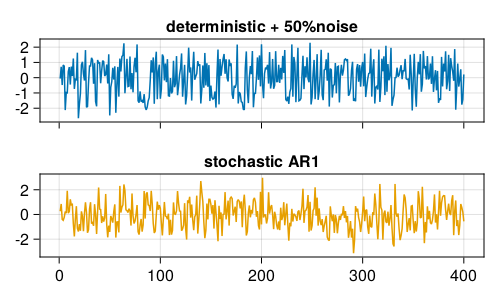

In [84]:
using DynamicalSystemsBase
ds = Systems.logistic(r = 4.0)
y = trajectory(ds, n-1)
# Add 50% observational noise
y = standardize(y) .+ 0.5randn(rng, n)
fig, ax1 = lines(y)
ax2, = lines(fig[2,1], x, color = Cycled(2))
ax1.title = "deterministic + 50%noise"
ax1.xticklabelsvisible = false
ax2.title = "stochastic AR1"
fig

Without labels, it isn't so easy to distinguish stochastic from nonlinear noisy, is it? Let's repeat the same surrogate test.

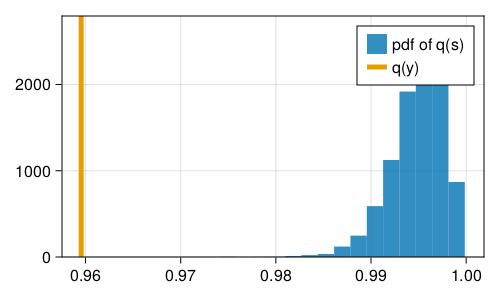

In [85]:
# make distribution of surrogate statistics
sgen = surrogenerator(x, RandomFourier(), rng)
qy = q(y)
qs = map(q, (sgen() for _ in 1:N))
# plot
fig, ax = CairoMakie.hist(qs; label = "pdf of q(s)")
vlines!(ax, qy; color = Cycled(2), linewidth = 5, label = "q(y)")
axislegend(ax)
ylims!(ax, 0, nothing)
fig

In [ ]:
q01, q99 = quantile(qs, [0.01, 0.99])
q01 ≤ qy ≤ q99 # if `false`, hypothesis can be rejected!

And keep in mind this is even though we have very short timeseries of just 400 points or so, but also that there is a 50% noise added to the first! Timeseries surrogate hypothesis testing is an integral part of any timeseries analysis workflow, whether it is causal, nonlinear, or statistical.

# Exercises - nonlinear timeseries analysis

## Detecting seizures in EEG timeseries

Use the following code to download an EEG timeseries of a person undergoing seizures. Perform a similar analysis to the one we performed using permutation entropy to identify when the seizure takes place.

_hint: in real world timeseries, when calculating the probabilities of the ordinal patterns, one must also tune the "delay time" `τ`, i.e., how far into the past to go when making the `m`-order ordinal permutations. Because the timeseries here has been subsampled, you can stay with the default option of `τ=1`_.

In [ ]:
using Downloads, DelimitedFiles
data_number = 18 # 18 r 19
file = Downloads.download("https://raw.githubusercontent.com/JuliaDynamics/NonlinearDynamicsTextbook/master/exercise_data/$(data_number).csv")
eeg = vec(DelimitedFiles.readdlm(file));

## Surrogates of atmospheric reflectance timeseries

Use the following code snippet to download two timeseries from an exercise dataset:

In [ ]:
using Downloads, DelimitedFiles
file = Downloads.download("https://raw.githubusercontent.com/JuliaDynamics/NonlinearDynamicsTextbook/master/exercise_data/11.csv")
M = readdlm(file)
x, y = M[:, 1], M[:, 2];

utilizing TimeseriesSurrogates.jl show that either of `x, y` **cannot** be distinguished from a linear stochastic process with a superimposed long term trend. You may use `method = TFTS(0.1)` as the surrogate method, which is suitable for this hypothesis.

_Note: in this exercise you are essentially reproducing the research of section 3.2 of [Datseris & Stevens (2021), Earth's Albedo and Its Symmetry](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021AV000440)_

# CausalityTools.jl

This is a Julia framework for estimating quantities about the "relationship" between data, typically timeseries. There are many different "relationship" quantifiers, most of which fall under the umbrella of causal inference.

In this short tutorial, we focus on only two use cases: 
- Estimating mutual information as a better correlation quantity than traditional statistical quantities
- Estimating/inferring a small causal graph out of a group of three timeseries using transfer entropy as the quantifier.

_Warning: the majority of the quantifiers in CausalityTools.jl require careful consideration for choosing their parameters. Moreover, inferring causal graphs also requires additional careful analysis to exclude common causes (also called confounding variables). These advanced topics however fall outside the scope of this introductory tutorial!_


**In-development version!** We are currently ready to published the much improved v2.0 of CausalityTools.jl and we will be using you as Guinea Pigs for it! To install this development version, use the following command:

```julia
import Pkg
Pkg.add(url = "https://github.com/JuliaDynamics/CausalityTools.jl/", rev = "v2")
```

and the documentation is here: https://juliadynamics.github.io/CausalityTools.jl/previews/PR187/ 

## Mutual information as a better measure of "correlation"

Typical correlation coefficients used in the literature such as Pearson/Spearman coefficients can misslead when estimating correlation between quantities that relate non-monotonically. For example, if $y = a \cdot x^2$ and $x \sim U(-1,1)$, both coefficients would yield 0 correlation between $y$ and $x$, even though they have such a clear relationship.

Let's demonstrate with an exemplary set of noisy timeseries

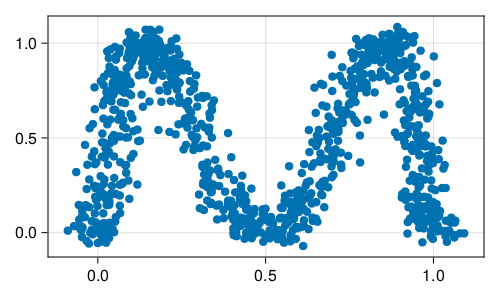

In [18]:
using DynamicalSystemsBase
lo, N = Systems.logistic(r=4), 1000
x = trajectory(lo, N-1)
y = trajectory(lo, N-1; Ttr = 2)
x .+= randn(N)/25; y .+= randn(N)/25
scatter(x, y)

In [87]:
using StatsBase: cor, corspearman
cor(x, y), corspearman(x, y)

(-0.035734765797092234, -0.03405500205500205)

Practically zero correlation according to these estimators...



An established method that estimates general correlation between $x$ and $y$ is their **mutual information (MI)**. Its most basic definition is given by
$$
MI(x,y)  = \sum_{n}\sum_{m}
    P_{xy}(x_n,y_m)\log\left(\frac{P_{xy}(x_n, y_m)}{P_{x}(x_n)P_{y}(y_m)}\right)
$$
where here $P_x(x_n)$ means casting the $n$-th data point of $x$ into a probability, and $P_{xy}$ means the same but now for a joint distribution between $x,y$. Intuitively speaking, MI measures how much knowing one of these observables reduces uncertainty about the other. Mathematically speaking, MI is a measure of the distance between the joint distribution $P_{xy}$ of $x, y$, and the distribution they'd have if they were independent, i.e., $P_{xy} = P_x P_y$.

In code you can calculate $MI$ with the `mutualinfo` function.

In [21]:
using CausalityTools

In [90]:
mutualinfo(ValueHistogram(21), x, y)

1.0739116596364333

Just like the discussion we had in the previous blocks, there are different ways to cast the data into probabilities.

In [91]:
mutualinfo(SymbolicPermutation(m=3), x, y)

0.40200183832440306

In addition here there are different ways to calculate the mutual information from existing probabilities (the formula quoted above is one estimator only). The interface is the same, you call `mutualinfo` but now with some other "estimator", now a "mutual information estimator" rather than a "probabilities estimator". For example

In [22]:
mutualinfo(KraskovStögbauerGrassberger2(k=5), x, y)

0.4628888119769542

However, this is an advanced topic that goes beyond this course. 

Alright, let's now focus on the simplest case of estimating the MI, via the histograms and joint histogram, of $x, y$

In [23]:
mutualinfo(ValueHistogram(21), x, y)

1.064821805008715

these MI numbers seem pretty random honestly. What we really care about is to be able to make a binary statement: are $x, y$ "correlated" according to this MI? To answer this, we do a surrogate test to reject the hypothesis "$x$ and $y$ are uncorrelated". What kind of surrogate generators satisfy this hypothesis by construction? Just shuffling the data, since this leaves $P_x$ and $P_y$ (and hence $P_xP_y$ invariant, but may ruin $P_{xy}$.

In [92]:
using TimeseriesSurrogates
surrox = surrogenerator(x, RandomShuffle())
surroy = surrogenerator(y, RandomShuffle())

Surrogate generator for input timeseries 1000-element Vector{Float64} with method:
RandomShuffle()

Just like we did in the case block of TimeseriesSurrogates.jl, we will compute the discriminatory statistic, here the mutual information, for the original data and a bunch of surrogates. For comparison, we'll also do the same for the Spearman coefficient.

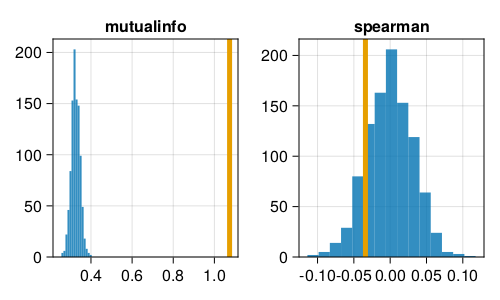

In [93]:
measures = [
    (x, y) -> mutualinfo(ValueHistogram(21), x, y),
    corspearman
]
names = ["mutualinfo", "spearman"]

N = 1000 # how many random surrogates
function surrogate_distribution(x, y, measure, N = 1000)
    original = measure(x, y)
    surrox = surrogenerator(x, RandomShuffle())
    # Quick note: we don't _actually_ have to make a surrogate
    # for the `y` timeseries here; just shuffling the `x`
    # timeseries is enough! But for the sake of
    # demonstration we go through the process one would do
    # for any probabilities estimator
    surroy = surrogenerator(y, RandomShuffle())
    distribution = Float64[]
    for i in 1:N
        sx, sy = surrox(), surroy()
        push!(distribution, measure(sx, sy))
    end
    return original, distribution
end

fig = Figure()
for (i, measure) in enumerate(measures)
    original, distribution = surrogate_distribution(x, y, measure)
    hist(fig[1, i], distribution; axis = (title = names[i],))
    vlines!(original; color = Cycled(2), linewidth = 5)
    ylims!(0, nothing)
end
fig

## Transfer entropy for causal tsa
Transfer entropy (TE) is one of the many measures used when performing **causal timeseries analysis**. Transfer entropy is defined by:

$$
TE_{x\to y} = H(y_t | y_{t-1:t-m}) - H(y_t | y_{t-1:t-m}, x_{t-1:t-n}) 
$$
with $H(x)$ the Shannon entropy of $H$.

TE quantifies how much _extra information we gain_ for the future of one timeseries $y$ (the “target”) if we know the past of $y$ and the past of another timeseries $x$ (the “source”), versus the information we would gain by only knowing the past of $y$.

In this section we'll use TE to estimate the causal relationship between three timeseries shown below, that have a known causal graph (from generation of data) that ahs two links: $(x \to y), (y \to z)$. 

_Note: we can't use Mutual Information in this context, because it is a symmetric measure! $MI(x,y) = MI(y,x)$!_ 

### Generate autoregressive processes with known causal relationship

In [25]:
using Random: MersenneTwister
function ar3(n::Int, rng = MersenneTwister(1234))
    x = zeros(n)
    y = zeros(n)
    z = zeros(n)
    x[1:3] .= randn(rng, 3)
    y[1:3] .= randn(rng, 3)
    z[1:3] .= randn(rng, 3)

    for i = 4:n
        x[i] = 0.6*sqrt(2)*x[i-1] - 0.71*x[i-2] + randn(rng)
        y[i] = 0.7*x[i-2] + 0.71*y[i-2] + randn(rng)
        z[i] = 0.67*z[i-2] - 0.6*y[i-1] - 0.2*z[i-3] + randn(rng)
    end
    return x, y, z
end

x, y, z = ar3(2*60*24)
data = Dict("x" => x, "y" => y, "z" => z)

Dict{String, Vector{Float64}} with 3 entries:
  "x" => [0.867347, -0.901744, -0.494479, -0.296325, 0.227705, 0.5137, 0.346335…
  "z" => [0.532813, -0.271735, 0.502334, -1.63504, -0.090054, -2.67248, 2.35223…
  "y" => [-0.902914, 0.864401, 2.21188, -0.577997, 3.07708, -0.868981, 0.840691…

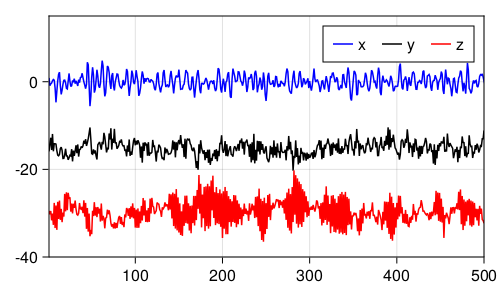

In [95]:
lines(x; color = "blue", label = "x")
lines!(y .- 15; color = "black", label = "y")
lines!(z .- 30; color = "red", label = "z")
axislegend(nbanks = 3)
xlims!(1, 500)
ylims!(-40, 15)
current_figure()

### Estimating tranfer entropy

The main function to use is `transferentropy`, that has the call signature:
```julia
transferentropy(embedding, estimator, x, y)
```
which estimates the transfer entropy _from_ `x` _to_ `y`. We already have the two input timeseries, so we move on to the second argument, _the estimator_.

To estimate transfer entropy, just like all other measures mentioned here, one needs to cast data into probabilities in some way. There are many estimators that can be used in this context, some of which estimate directly transfer entropy, some estimate some differenetial entropy. The online documentation has more information on the estimators.

Here we will once again use the simplest possible way to cast data into probabilities: the probabilities estimator `ValueHistogram`!

In [98]:
probest_for_te = ValueHistogram(3)

ValueHistogram{RectangularBinning{Int64}}(RectangularBinning{Int64}(3, false))

You might be surprised that we will only use 3 bins per data dimension... Sounds pretty low right? Well, yes, but you need to take into account how many data dimensions we have when attempting to compute transfer entropy. Recall that we need to compute the entropy:
$$
H(y_t | y_{t-1:t-m}, x_{t-1:t-n})
$$
The first argument is a timeseries, so 1 dimension. However, the second has `m-1` dimensions, because each "data point" of $y_{t-1:t-m}$ is composed of `m-1` values from the $y$ timeseries! Hence, we need to compute a histogram in `m-1` dimensional space. Even worse, we also need the _joint_ histograms! And in the case where we include also the past of `x`, our dimension becomes in total `m + n - 1` which can get very large depending on how much of the past we include!

Hence, we need to be reserved in how many bins we will use for the histograms, because if we use a lot of bins most of them will be empty, leading to low accuracy in the computation of the transfer entropy.

There the last argument we need to choose is `embedding`, the **delay embedding** of the data. Without going into too many details, for this application this means choosing `m, n`, i.e., how much of the past of $y$ and $x$ to include.

This decision is encapsulated in an instance of `EmbeddingTE` (standing for "embedding for transfer entropy"), like so:

In [99]:
using CausalityTools
emb_for_te = EmbeddingTE(; dS = 3, dT = 4)

EmbeddingTE(dS=3, dT=4, dC=1, dTf=1, τS=-1, τT=-1, τC=-1, ηTf=1)

Here `dS` meant the "embedding dimension of the Source" and `dT` meant the "embedding dimension of the Target" (TE is estimated _from_ source $x$ _to_ target $y$). Other arguments are things that we will not discuss in this lecture!

In any case, now we can use this embedding information, and the probabilities estimator, into the `transferentropy` function as follows:

In [100]:
transferentropy(emb_for_te, probest_for_te, x, y)

0.19223144391518066

Just like it was the case with mutual information, the significance of this number can be estimated via surrogate tests, which we will do in a moment!

### Optimizing parameters for the estimation

Estimating the TE like above has lots of input choices regarding the number of bins and how far to go into the past. The number of bins is constrained by the amount of data we have, but how far into the past we can go can be optimized using standard nonlinear dynamics techniques included in the DelayEmbeddings.jl package.

In CausalityTools.jl we have made a simple wrapper function that uses DelayEmbeddings.jl and provides an optimized embedding for given `x, y` timeseries that go into `transferentropy`. You can call it as follows:

In [101]:
optimal_embedding = optimize_marginals_te(OptimiseTraditional(), x, y; exclude_source = true)

EmbeddingTE(dS=1, dT=5, dC=1, dTf=1, τS=-1, τT=-1, τC=-1, ηTf=1)

In [102]:
transferentropy(optimal_embedding, probest_for_te, x, y)

0.05541655551424807

### Causal graph from transfer entropy

Alright! Now we are ready to compute the TE between all _directional_ pairs of the three timeseries `x, y, z`. These pairs are:

In [103]:
using Combinatorics: multiset_permutations
variable_pairs = multiset_permutations(("x", "y", "z"), 2)
collect(variable_pairs)

6-element Vector{Vector{String}}:
 ["x", "y"]
 ["x", "z"]
 ["y", "x"]
 ["y", "z"]
 ["z", "x"]
 ["z", "y"]

In [104]:
results_te = Dict{String, Float64}()
for (source, target) in variable_pairs
    s, t = data[source], data[target]
    est = ValueHistogram(3)
    # Shannon transfer entropy with traditional delay-embedding optimisation. 
    # Skip optimising for source time series (you don't need to understand this now). 
    embedding = optimize_marginals_te(OptimiseTraditional(), s, t; exclude_source = true)
    results_te["$source → $target"] = transferentropy(embedding, est, s, t) 
end
results_te

Dict{String, Float64} with 6 entries:
  "x → y" => 0.0554166
  "x → z" => 0.0276461
  "y → z" => 0.107256
  "z → x" => 0.0310366
  "y → x" => 0.0371841
  "z → y" => 0.0360582

Very nice! This is already a "causal graph" (terms and conditions apply), with the strength of the links being the above numbers.

### Eliminating insignificant links

The above "causal graph" is fully connected. We can do much better than that, by eliminating insignificant or spurrious links in the graph via surrogate tests! For each pair in this graph, we have to make a dedicated surrogate test, very similar in spirit with the example of the mutual information.
 
Because the probabilities estimator is `ValueHistogram`, the appropriate surrogates are those generated with simply shuffling the timeseries around!

In [105]:
results_surr = Dict()
nsurr = 100
for (source, target) in variable_pairs
    s, t = data[source], data[target]
    est = ValueHistogram(3)
    # Optimise transfer entropy parameters *before* computing transfer entropy on
    # surrogate data, so that we use identical parameters for real and shuffled data. 
    embedding = optimize_marginals_te(OptimiseTraditional(), s, t; exclude_source = true)
    ŝ = surrogenerator(s, RandomShuffle())
    te_surr = [transferentropy(embedding, est, ŝ(), t) for i = 1:nsurr]
    results_surr["$source → $target"] = te_surr
end
results_surr

Dict{Any, Any} with 6 entries:
  "x → y" => [0.0433005, 0.0398284, 0.0428038, 0.0394565, 0.0358692, 0.0396165,…
  "x → z" => [0.0265681, 0.0250555, 0.0315874, 0.0293445, 0.0243791, 0.0303093,…
  "y → z" => [0.0230548, 0.0318878, 0.0310125, 0.0312579, 0.0253844, 0.0299137,…
  "z → x" => [0.0319399, 0.0297704, 0.0315703, 0.0313589, 0.0347524, 0.0315343,…
  "y → x" => [0.0409778, 0.0338697, 0.0416263, 0.0286575, 0.03992, 0.0300415, 0…
  "z → y" => [0.0354153, 0.0453079, 0.0382885, 0.0399693, 0.0413016, 0.0469605,…

In these results, each pair is mapped to a _distribution_ of the TE values for surrogate data. So, just like in the MI case, we check whether the real TE value is outside the majority of the distribution mass, e.g., beyond the 1-99 quantiles. 

Here is a nice visualization that shows this!

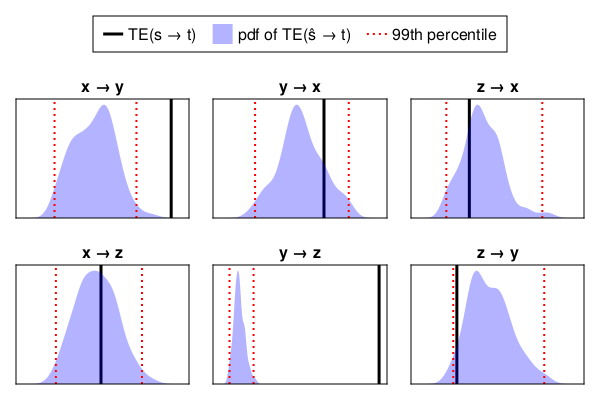

In [106]:
using Statistics: quantile
α = 0.01 # quantile

fig = Figure(resolution = (600,400))
names = sort(collect(keys(results_te)))
axs = [Axis(fig[idx[1], idx[2]]) for idx in CartesianIndices((2, 3))]

for (ax, name) in zip(axs, names)
    vlines!(ax, results_te[name], color = :black, linewidth = 3,
            label = "TE(s → t)")
    density!(ax, results_surr[name], color = (:blue, 0.3),
            label = "pdf of TE(ŝ → t)");
    vlines!(ax, quantile(results_surr[name], [α, 1-α]), 
            label = "$(ceil(Int, (1-α)*100))th percentile",
            color = :red, linestyle = :dot, linewidth = 2)
    hidedecorations!(ax)
    ylims!(ax, 0, nothing)
    ax.title = name
end
fig[0, :] = Legend(fig, content(fig[1,1]), nbanks = 3, tellheight = true)
fig

Fantastic! We can see that the TE correctly inferred the causal graph $(x \to y), (y \to z)$ when taking into account the surrogate significance tests! TE also claims that the influence of $y$ on $z$ is much larger than the influence of $x$ on $y$. However what this means when it comes down to the causal relationship is ambiguous.

### Concluding remarks

- Transfer entropy is just one method for detecting directional influences from time series.
- The pairwise analysis you did here is as naive as possible. In real applications, parameters must be tuned carefully!
- In real applications, you also need to do a conditional variant to account for _confounding variables_ (also called _common drivers_). This variant is called "partial transfer entropy".
- Many very sophisticated and powerful methods for inferring causal graphs using conditional independence testing exist (see e.g. [Runge et al. 2019 Nat. Comm.](https://www.nature.com/articles/s41467-020-15195-y/)).

# Exercises - relational timeseries analysis

## MI of atmospheric reflectance timeseries

Use the following code snippet to load the same atmospheric reflectance data as those used in the TimeseriesSurrogates.jl exercise, but now de-trended:

In [ ]:
using Downloads, DelimitedFiles
file = joinpath(@__DIR__, "..", "data", "atmospheric_reflectance_detrended.tsv")
M = readdlm(file)
x, y = M[:, 1], M[:, 2];

Utilize the `mutualinfo` function from CausalityTools.jl examine if the two timeseries are significantly correlated. Repeat our attempt also with using two more different estimators for the probabilities going into mutual information: `Dispersion()` and `SymbolicPermutation(m = 3)`.

_Note: in this exercise you are essentially reproducing the research of section 3.2 of [Datseris & Stevens (2021), Earth's Albedo and Its Symmetry](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021AV000440)_

## Importance of parameters in an output value

Imagine you have some model, that is generating a trajectory, and from the trajectory you extract one quantity (a real number) that is of interest to you. Your model has many parameters, and you want to quantify which of the model parameters significantly affect the value of your quantity of interest.

This is a scenario where a simple application of mutual information gives the wanted information. Use the following code to load a dataset:

In [ ]:
using DelimitedFiles
data = readdlm(joinpath(@__DIR__, "..", "data", "parameter_importance.csv"))
x = data[:, 1]
params = data[:, 2:end];

In this data, the first column `x` is an output diagnostic of some model evolution, and the rest of the columns are input parameters to the model. Use a mutual information analysis to order the parameters by their importance in shaping the value of `x`. A measure of importance can be the **normalized mutual information**, which is defined based on the distribution of MI values one obtains from the surrogate test:

$$
nMI = \frac{|MI - mean(D)|}{3 std(D)}
$$
with $D$ the distribution and $MI$ the real MI value. (of course, instead of $3\sigma$ you could use the width of the central 1-99% quantile or anything else). $nMI>1$ means significant correlation, or in this case importance of the parameter, and the larger the $nMI$ the larger the importance.

_hint: the input data here are not ordered timeseries. As such, the probabilities estimator that makes most sense to use is `ValueHistogram`_

_Note: in this exercise you are essentially reproducing the research of section 5 of [Schmidt & Hohenegger (2023), to be published](https://mpimet.mpg.de/en/staff/atmosphere/translate-to-englisch-luca-schmidt-1)_

## Estimator dependence of the TE causal graph application

The choice of estimator will (sometimes strongly) affect a TE-based analysis. In the hHere we used the naive `ValueHistogram(3)` discrete probabilities estimator. It computes transfer entropy as a sum of four entropy terms, without any bias correction. 

`ValueHistogram(3)` uses 3 subdivisions along each dimension to construct bins. The minimum dimension of the embedding for a transfer entropy analysis is 3. Therefore, for `ValueHistogram(3)`, there are _at least_ `3^3 = 27` possible bins/states which observations can occupy. What do you think happens to the reliability of the entropy estimates (and thus the transfer entropy estimate) when increasing the number of boxes? Does it increase or decrease? Repeat the TE example showed here for `ValieHistogram(b)` with `b` from `2` to `7`.

Then, repeat the example, now using a completely different estimator: `Zhu1(; k = length(x) ÷ 40)`. The `Zhu1` estimator computes *differential* transfer entropy, and has built-in bias-correction.

## Causal direction in timeseries pairs

Use the following code to download a pair of timeseries `x, y` from datasets 14 or 15:

In [ ]:
using Downloads, DelimitedFiles
data_number = 14 # 14 or 15
file = Downloads.download("https://raw.githubusercontent.com/JuliaDynamics/NonlinearDynamicsTextbook/master/exercise_data/$(data_number).csv")
x, y = eachcol(DelimitedFiles.readdlm(file));

Perform a transfer entropy analysis of the two timeseries, and use that to deduce whether one timeseries is a causal driver of the other or if no significant causal direction can be inferred.

_hint: as it is not known whether the timeseries represent discrete-time processes, it is not clear what whether the delay time should be equal to 1, and you probably want to optimize this_